# Building a mesh from GeoTIFF files

<div class="alert alert-block alert-info"> GeoTIFF files are raster dataset embedding Geographic Information (latitude, longitude, map projection etc.) The geographic data of a GeoTIFF file can be used to position the image in the correct location and geometry and build structured and unstructured meshes used in our landscape evolution model.  

In this example, we use a dataset of the Blue Mountains region (100 km West of Sydney AU) that can be extracted from the ASTER Global DEM from USGS Global Data Explorer website: 
**https://gdex.cr.usgs.gov/gdex/**</div>


You can find an non-exhaustive list of available digital elvation dataset in the following website: 
+ https://github.com/openterrain/openterrain/wiki/Terrain-Data

***

<img src="images/bluemountains.png" width="70%">

***

## Notebook contents

   - [Converting from lon/lat to metres](#Converting-from-lon/lat-to-metres)
   - [Clipped elevation grid](#Clipped-elevation-grid)
   - [X & Y axes](#X-&-Y-axes)
   - [Structured elevation grid](#Structured-elevation-grid)
   - [Unstructured elevation grids](#Unstructured-elevation-grids)
   


In [1]:
import pycpt
import lavavu

import meshio
import numpy as np
import pygmsh as pg
import stripy as stripy
import fillit as pitfill

from scipy.interpolate import RectBivariateSpline

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

label_size = 8
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

# Converting from lon/lat to metres

To reproject the grid from lon/lat coordinates to UTM (metres), two main libraries are available within the Docker image:

+ `pygeotools` -- https://github.com/dshean/pygeotools
+ `rasterio` -- https://github.com/mapbox/rasterio

First, we specify our DEM filename:

In [2]:
filename = 'data/BlueMountains.tif'

If `pygeotools` is used, you will load the `warplib` library and will need to define the resolution `utmRes` and the **coordinate system** you want to used for your new projection `utmProj`. 

As an example, here we use the UTM zone 55 for the southern hemisphere based on the location of our dataset. 
Once the `warplib` library has done the projection transformation you will be able to access the projected dataset as a numpy masked array using the `iolib` library from `pygeotools`.


It will typically be used as follows:

``` python
from pygeotools.lib import iolib,geolib,warplib

utmRes = 30.
utmProj = "+proj=utm +zone=55 +south +datum=WGS84 +ellps=WGS84 "
utmData = warplib.diskwarp_multi_fn( [filename], t_srs = utmProj, res = utmRes)
utm = iolib.ds_getma(utmData[0]) 

```

Below, we show how this can be done using `rasterio`. First we load the required libraries and then define the requested projection (here we used **EPSG reference** for the region `EPSG:32756` - available from http://spatialreference.org/ref/epsg/). 

In [3]:
import rasterio
from rasterio import crs
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Name of the reprojected UTM file to be created
outputfile = 'data/BlueMountainsUTM.tif'

# Reproject to UTM zone 55 S 
dst_crs = {'init': 'EPSG:32756'}

# Requested reprojected dataset resolution (metres)
utmRes = 50.

We then use the following cell to make the projection and get the interpolated elevation points at the requested resolution (`elev` -- a numpy masked array)

In [4]:
with rasterio.drivers(CHECK_WITH_INVERT_PROJ=True):
    with rasterio.open(filename) as src:

        profile = src.profile
        if src.nodata is None:
            nodata = -32768.0
        else:
            nodata = src.nodata

        # Calculate the ideal dimensions and transformation in the new crs
        dst_affine, dst_width, dst_height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds, resolution=utmRes)

        # update the relevant parts of the profile
        profile.update({
            'crs': dst_crs,
            'transform': dst_affine,
            'affine': dst_affine,
            'width': dst_width,
            'height': dst_height
        })
       
        # Reproject and write each band
        with rasterio.open(outputfile, 'w', **profile) as dst:
            src_array = src.read()
            dst_array = np.empty((int(dst_height), int(dst_width)), dtype='int16')

            reproject(
                    # Source parameters
                    source=src_array,
                    src_crs=src.crs,
                    src_transform=src.affine,
                    src_nodata=nodata,

                    # Destination paramaters
                    destination=dst_array,
                    dst_transform=dst_affine,
                    dst_crs=dst_crs,
                    dst_nodata=nodata,

                    # Configuration
                    resampling=Resampling.nearest,
                    num_threads=2)

            dst.write(dst_array,1)
            elev = np.ma.masked_where(dst_array == nodata, dst_array)

We can look at the `metadata` associated with the new GeoTIFF file using for example:

In [5]:
dst.meta

{'affine': Affine(50.0, 0.0, 202412.89054090047,
        0.0, -50.0, 6305230.473241859),
 'count': 1,
 'crs': CRS({'init': u'epsg:32756'}),
 'driver': u'GTiff',
 'dtype': 'int16',
 'height': 2657,
 'nodata': -32768.0,
 'transform': (202412.89054090047, 50.0, 0.0, 6305230.473241859, 0.0, -50.0),
 'width': 1907}

# Clipped elevation grid

We can visualise the new elevation array using the following function:

In [6]:
def plotElevation( data, cmin, cmax, colormap):
    '''
    data: dataset to plot
    cmin,cmax: extent of the colormap
    colormap: color scale to use   
    '''
    
    # Figure size is defined here
    fig = plt.figure(1, figsize=(8,8))
    
    ax = plt.gca()
    im = ax.imshow(np.flipud(data), interpolation='nearest', cmap=colormap,
                     vmin=cmin, vmax=cmax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = plt.colorbar(im,cax=cax)
    plt.tight_layout()

    plt.show()
    plt.close(fig)

We choose to use `pycpt` -- Python tools to load and handle **cpt** (GMT format) color maps for use with matplotlib (_e.g._ from cpt-city)

You can pick a colorbar from the following website:
+ http://soliton.vm.bytemark.co.uk/pub/cpt-city/index.html

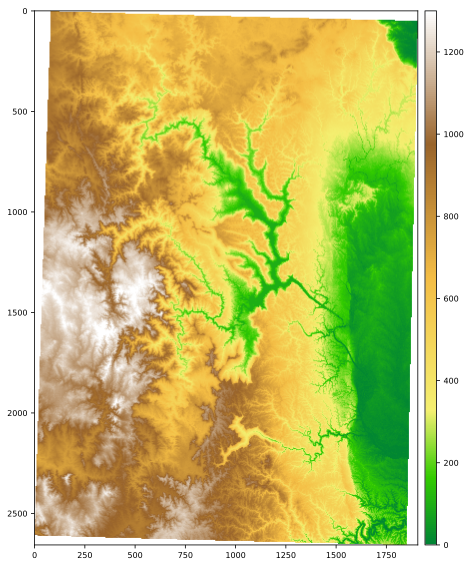

In [7]:
topocmap = pycpt.load.cmap_from_cptcity_url('td/DEM_screen.cpt')
plotElevation( elev, 0, 1300, topocmap)

As you can see from the figure above, we will need to **clip** our array to remove the `nodata` values induced by the reprojection... We do that by just selecting the extent of the rows and columns number from our `elev` numpy array...

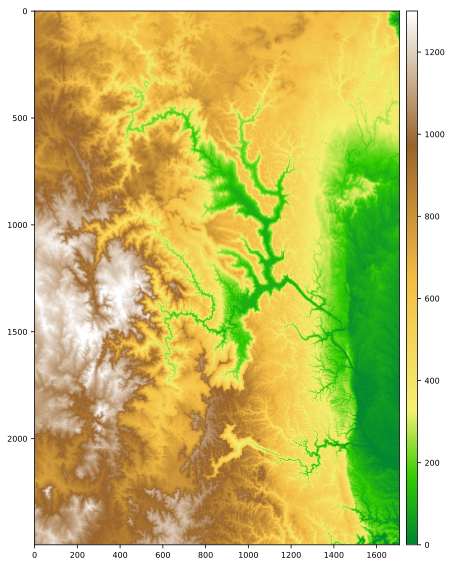

In [8]:
plotElevation( elev[80:-80,100:-100], 0, 1300, topocmap)

This extent seems to work :-), let's see if we still have some masked values

In [9]:
np.ma.is_masked(elev[80:-80,100:-100])

False

We then defined a new elevation array `dem` based on the clipped one:

In [10]:
dem = elev[80:-80,100:-100]

# X & Y axes

To keep your coordinates system for post-processing and to potentially reproject the outputs from the landscape evolution model in another geospatial system we needs to specify the X and Y axes.

We do it like this:

In [11]:
xMin = dst.transform[2]
xMax = dst.transform[2] + abs(dst.transform[0])*dst_width

yMin = dst.transform[5] - abs(dst.transform[4])*dst_height
yMax = dst.transform[5]

print("Initial DEM:\n")

print("Lower left coordinates       Xmin: {}, Ymin: {}".format(xMin,yMin))
print("Upper right coordinates      Xmax: {}, Ymax: {}".format(xMax,yMax))

Initial DEM:

Lower left coordinates       Xmin: 202412.890541, Ymin: 6172380.47324
Upper right coordinates      Xmax: 297762.890541, Ymax: 6305230.47324


We can now create the X and Y coordinates, at this point we can choose to decrease the resolution if needed by using the `step` parameter (integer)

In [12]:
step = 4
spacing = utmRes*step
print spacing
nZ = dem[::step,::step]

from scipy.ndimage.filters import gaussian_filter

nZ = gaussian_filter(nZ, sigma=2)

pitClass = pitfill.depressionFillingBarnes(nZ,eps=1.e-6,sealevel=10.)
Z = pitClass.performPitFillingStruct()

nx = Z.shape[1]
ny = Z.shape[0]

minX, maxX = xMin, xMin+spacing*nx
minY, maxY = yMin, yMin+spacing*ny

xcoords = np.arange(minX, maxX, spacing)
ycoords = np.arange(minY, maxY, spacing)

X, Y = np.meshgrid(xcoords, ycoords)

coords = np.vstack([X.ravel(), Y.ravel()])
coords = np.vstack([coords, Z.ravel()]).T


print("Clipped DEM:\n")

print("Resolution (m)            res: {}".format(spacing))
print("Number of points         nbpt: {}".format(coords.shape[0]))
print("Elevation map shape        nx: {}, ny: {}\n".format(nx,ny))

print("Lower left coordinates   Xmin: {}, Ymin: {}".format(minX,minY))
print("Upper right coordinates  Xmax: {}, Ymax: {}".format(maxX,maxY))

200.0
Clipped DEM:

Resolution (m)            res: 200.0
Number of points         nbpt: 266875
Elevation map shape        nx: 427, ny: 625

Lower left coordinates   Xmin: 202412.890541, Ymin: 6172380.47324
Upper right coordinates  Xmax: 287812.890541, Ymax: 6297380.47324


# Unstructured elevation grid

In [13]:
interpolateFct = RectBivariateSpline(xcoords,ycoords,Z.T)

## Using pyGmsh library

Another method consists in using `pyGmsh` library, which is a Python interface to `Gmsh`: a powerful mesh generation tool:

- https://github.com/nschloe/pygmsh

The resolution of the mesh is defined based on the characteristic length parameter `lcar` here defined based on the `spacing` value (spacing = utmRes $\times$ step).

There are several different ways of defining the mesh, here we use an approach similar to what we've done previously with `stripy` and use the border coordinates to create our delaunay triangulation.

In [ ]:
spacing = utmRes*step

# Initialise pyGmsh geometry
geom = pg.built_in.Geometry()

# Define the border of the mesh.
poly = geom.add_polygon([
    [minX, minY, 0.0],
    [maxX, minY, 0.0],
    [maxX, maxY, 0.0],
    [minX, maxY, 0.0]
    ],
    lcar=spacing
    )

# Generate the mesh
pts, cells, _, _, _ = pg.generate_mesh(geom, verbose=True, dim=2) 

In [ ]:
print("Unstructured Grid:\n")

print("Number of points         nbpt: {}".format(pts.shape[0]))
print("Number of faces       nbcells: {}".format(cells['triangle'].shape[0]))

Similar to the other examples, we perform the elevation interpolation on the triangulation coordinates:

In [ ]:
# Interpolation of the elevation on the triangulation
evalZG = interpolateFct.ev(pts[:,0], pts[:,1])

# Creation of the X,Y,Z coordinates of the unstructured grid
pts[:,2] = evalZG

## Pit filling

In [ ]:
fillB = pitfill.depressionFillingBarnes(coords=pts,eps=1.e-4,cells=cells['triangle'],cartesian=False,first=1)
fZ = fillB.performPitFillingUnstruct()

# Creation of the X,Y,Z coordinates of the unstructured grid
vertsR = np.insert(pts[:,:2], 2, values=fZ, axis=1)

And use lavavu to visualise the new unstructured grid. As in the other cases, we need to give to the **lavavu** function the following things:
+ points coordinates (`pts`) 
+ the IDs of the connected points forming each triangle faces (`cells['triangle']`).

In [ ]:
lv = lavavu.Viewer(border=True, background="#FFFFFF", resolution=[700,700], near=-10.0)

# Core 
lvTriG = lv.triangles("DelGmsh",  wireframe=True, colour="#161616", opacity=1.0)
lvTriG.vertices(vertsR)
lvTriG.indices(cells['triangle'])
lvTriG.values(fZ)
lvTriG.colourmap("geo", range=[-1800.,1800.])

lv.translation(823.959, 14666.457, -48052.191)
lv.rotation(-28.235, 4.249, -0.51)
lv.scale('z', 4)

lv.control.Checkbox(property='axis')
lvTriG.control.Checkbox(property='wireframe', label="wireframe")
lv.control.Panel()
lv.control.ObjectList()
lvTriG.control.Range(command='scale z', range=(1,20), step=1., value=4)
lv.control.show()

We can here as well save the unstructured mesh as a VTU file (VTK format) using meshio library

In [ ]:
pts03 = vertsR
pts03[:,2] = 0.
mesh = meshio.Mesh(pts03, cells, {'Z':fZ})
meshio.write("data/BlueMountains.vtk", mesh)